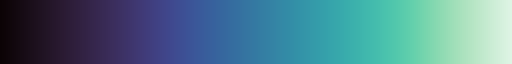

In [82]:
import numpy as np
from scipy.spatial import Delaunay
import pandas as pd
from itertools import combinations
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.tri as mtri
matplotlib.rcParams['figure.dpi'] = 360
matplotlib.rcParams['text.usetex'] = True
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
})
# plt.style.use('dark_background')
cmap = sns.color_palette('mako', as_cmap=True)
cmap

### Data

In [4]:
base_url = './data/coord/'

One rosette

In [15]:
rosette_id = 0
data = pd.read_csv(f'{base_url}ELG_{rosette_id}_clustering_data.ecsv', comment='#',
                   sep=r'\s+', engine='python') #delimited by whitespace and # for yaml header
rand_data = pd.read_csv(f'{base_url}ELG_{rosette_id}_clustering_rand.ecsv', comment='#',
                        sep=r'\s+', engine='python')
data.head()

,TARGETID,X,Y,Z
0,39627853658065415,-3291.701508,2007.089996,192.291880
1,39627847618265847,-3082.305890,1886.299382,153.573606
2,39627865779603949,-3981.150804,2175.235326,254.320000
3,39627853658064960,-2843.031718,1735.174467,157.212263
4,39627847656015720,-3807.864548,2124.633986,182.875014


### Delaunay triangulation

In [41]:
data_, rand_data_ = data.copy(), rand_data.copy()
data_['RAN'] = False
rand_data_['RAN'] = True

dataset = pd.concat([data_, rand_data_], ignore_index=True) #! now i have data and random in the same dataset
dataset.head()

,TARGETID,X,Y,Z,RAN
0,39627853658065415,-3291.701508,2007.089996,192.291880,False
1,39627847618265847,-3082.305890,1886.299382,153.573606,False
2,39627865779603949,-3981.150804,2175.235326,254.320000,False
3,39627853658064960,-2843.031718,1735.174467,157.212263,False
4,39627847656015720,-3807.864548,2124.633986,182.875014,False


In [79]:
tri = Delaunay(dataset[['X', 'Y', 'Z']].values)
triang = mtri.Triangulation(dataset['X'], dataset['Y'])

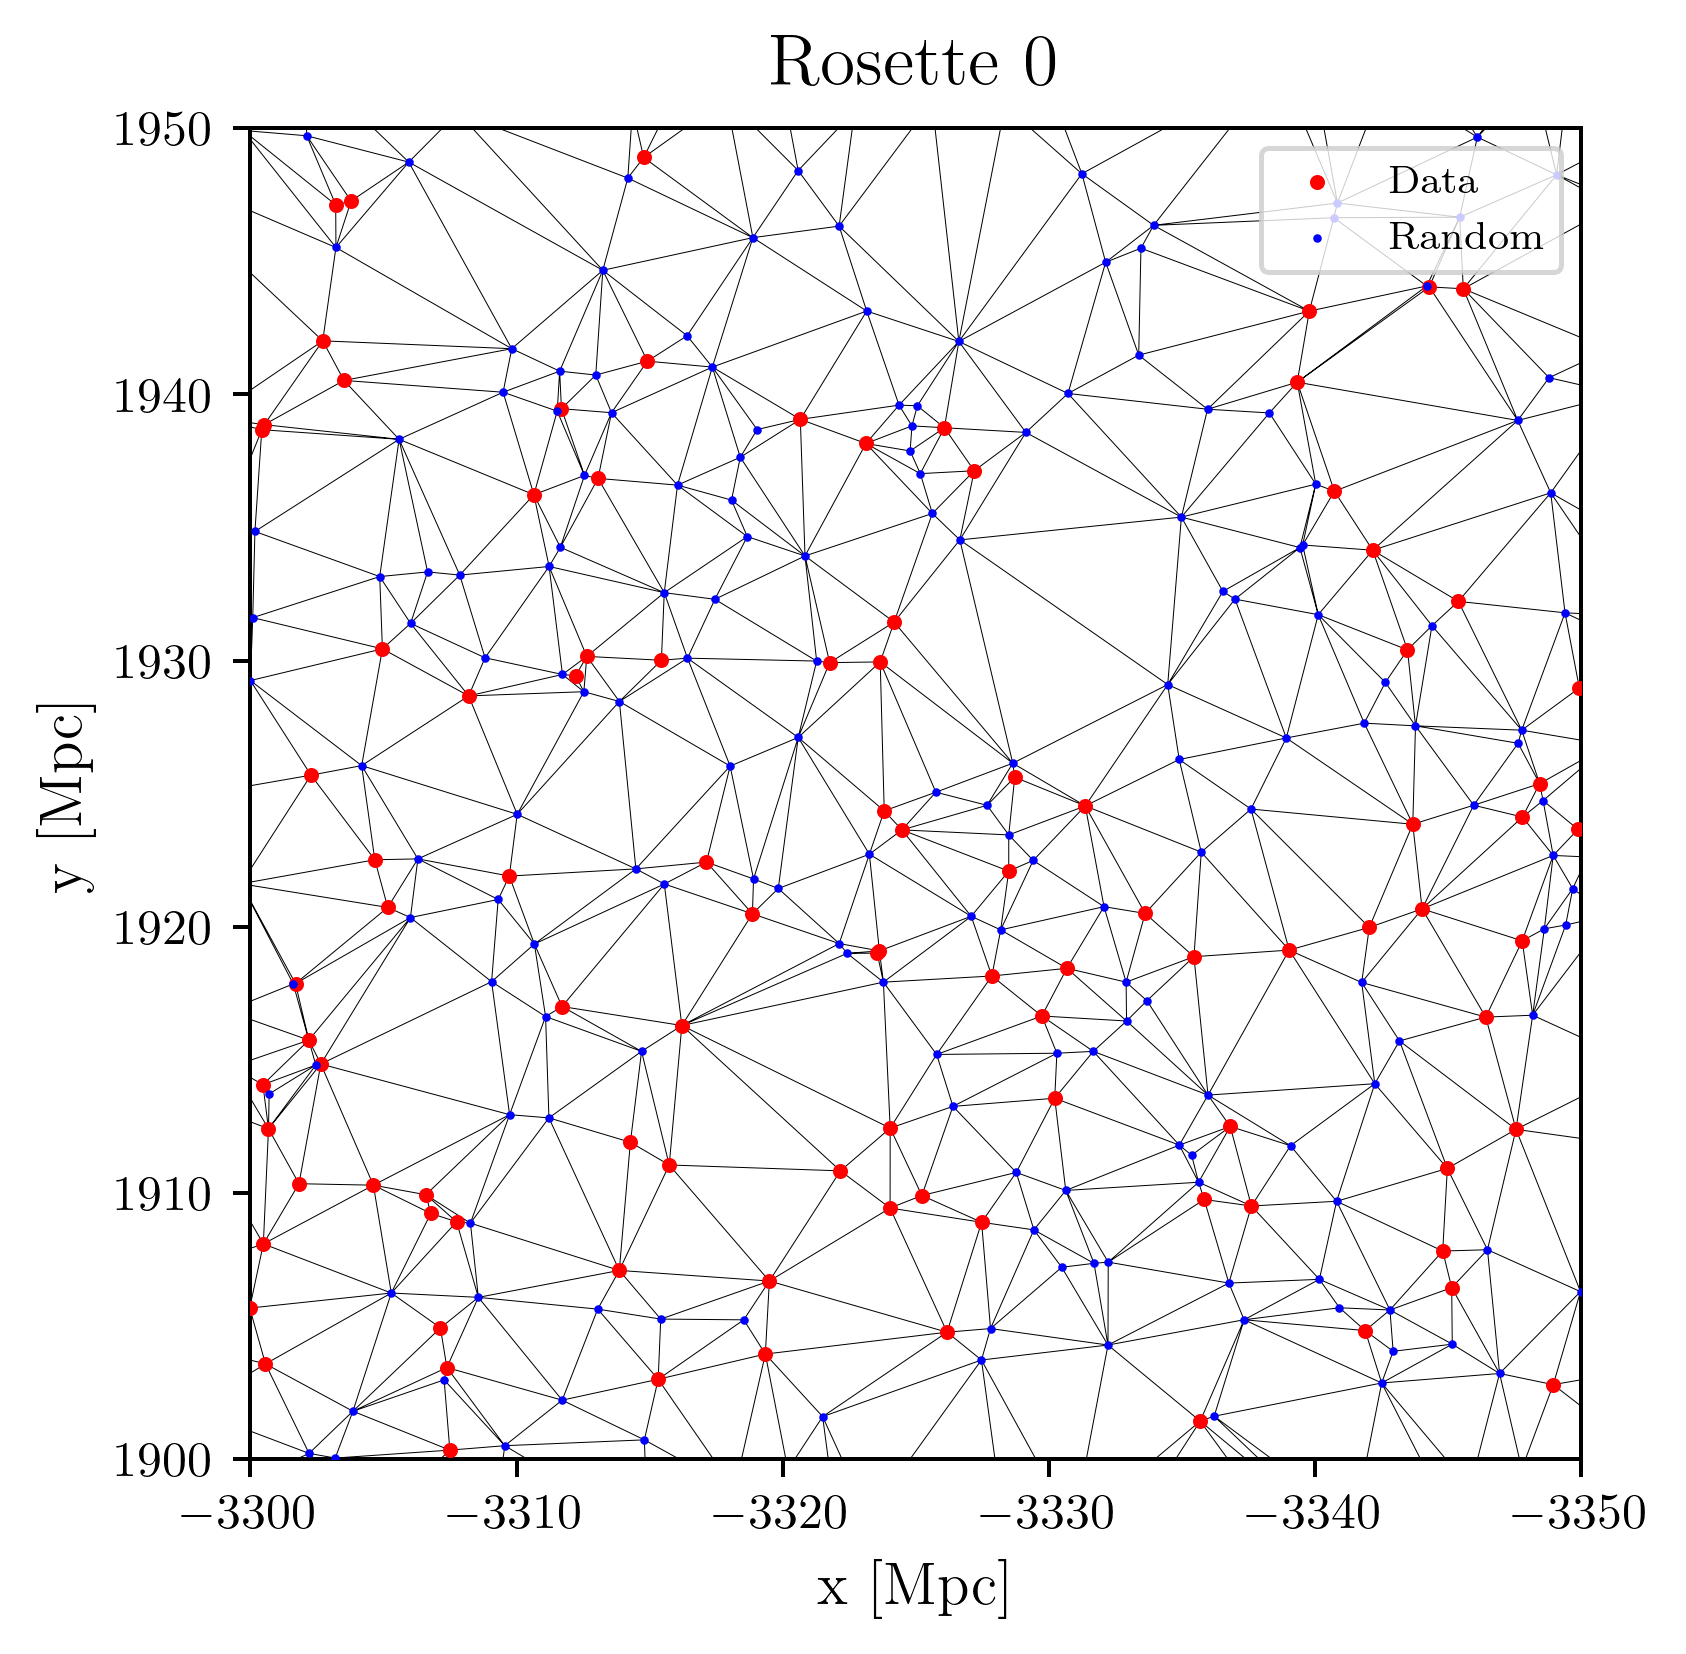

In [83]:
fig, ax = plt.subplots()

ax.triplot(triang, linewidth=0.2, color='k', zorder=1)
ax.scatter(data_['X'], data_['Y'], label='Data', s=4, c='r', zorder=3)
ax.scatter(rand_data_['X'], rand_data_['Y'], label='Random', s=0.5, c='b', zorder=5)

ax.legend(loc='upper right', fontsize=8)
ax.set_title(f'Rosette {rosette_id}', y=1.01)

ax.set_xlim(-3300, -3350)
ax.set_ylim(1900, 1950)
ax.set_xlabel('x [Mpc]')
ax.set_ylabel('y [Mpc]')
ax.set_box_aspect(1)
plt.show()

### Get $\space r$

In [44]:
def compute_r(df):
    coords  = df[['X', 'Y', 'Z']].values
    is_data = ~df['RAN'].values

    tri = Delaunay(coords)

    #! adjacency list for neighbors
    neighbors = {i: set() for i in range(len(coords))}
    for simplex in tri.simplices:
        for i, j in combinations(simplex, 2):
            neighbors[i].add(j)
            neighbors[j].add(i)

    r = np.zeros(len(coords), dtype=float)
    for i, nbrs in neighbors.items():
        n_data = int(np.sum(is_data[list(nbrs)]))
        n_rand = len(nbrs) - n_data
        if (n_data + n_rand) > 0:
            r[i] = (n_data - n_rand) / (n_data + n_rand)
        else:
            r[i] = 0.0

    out = df.copy()
    out['r'] = r
    return out

In [47]:
df_r = compute_r(dataset)
df_r.head()

,TARGETID,X,Y,Z,RAN,r
0,39627853658065415,-3291.701508,2007.089996,192.291880,False,-0.411765
1,39627847618265847,-3082.305890,1886.299382,153.573606,False,-0.800000
2,39627865779603949,-3981.150804,2175.235326,254.320000,False,-0.272727
3,39627853658064960,-2843.031718,1735.174467,157.212263,False,-0.428571
4,39627847656015720,-3807.864548,2124.633986,182.875014,False,0.000000


### Classify

In [88]:
def classify_r(df):
    r = df['r'].values
    conds = [(r >= -1.0) & (r <= -0.9),
             (r > -0.9) & (r <= 0.0),
             (r > 0.0) & (r <= 0.9),
             (r > 0.9) & (r <= 1.0),]
    choices = ['void', 'sheet', 'filament', 'knot']
    df = df.copy()
    df['TYPE'] = np.select(conds, choices, default='error')
    return df

In [89]:
df_typed = classify_r(df_r)
df_typed.head()

,TARGETID,X,Y,Z,RAN,r,TYPE
0,39627853658065415,-3291.701508,2007.089996,192.291880,False,-0.411765,sheet
1,39627847618265847,-3082.305890,1886.299382,153.573606,False,-0.800000,sheet
2,39627865779603949,-3981.150804,2175.235326,254.320000,False,-0.272727,sheet
3,39627853658064960,-2843.031718,1735.174467,157.212263,False,-0.428571,sheet
4,39627847656015720,-3807.864548,2124.633986,182.875014,False,0.000000,sheet


In [90]:
df_typed['TYPE'].describe() #* no erroooors

count     35501
unique        4
top       sheet
freq      26970
Name: TYPE, dtype: object

### Plot

In [91]:
coords2d = df[['X','Y']].values
tri = Delaunay(coords2d)

is_real = ~df['RAN'].values
# types = df['TYPE'].unique()
types = ['void', 'sheet', 'filament', 'knot'] #? sale 'sheet','filament','knot','void' del df

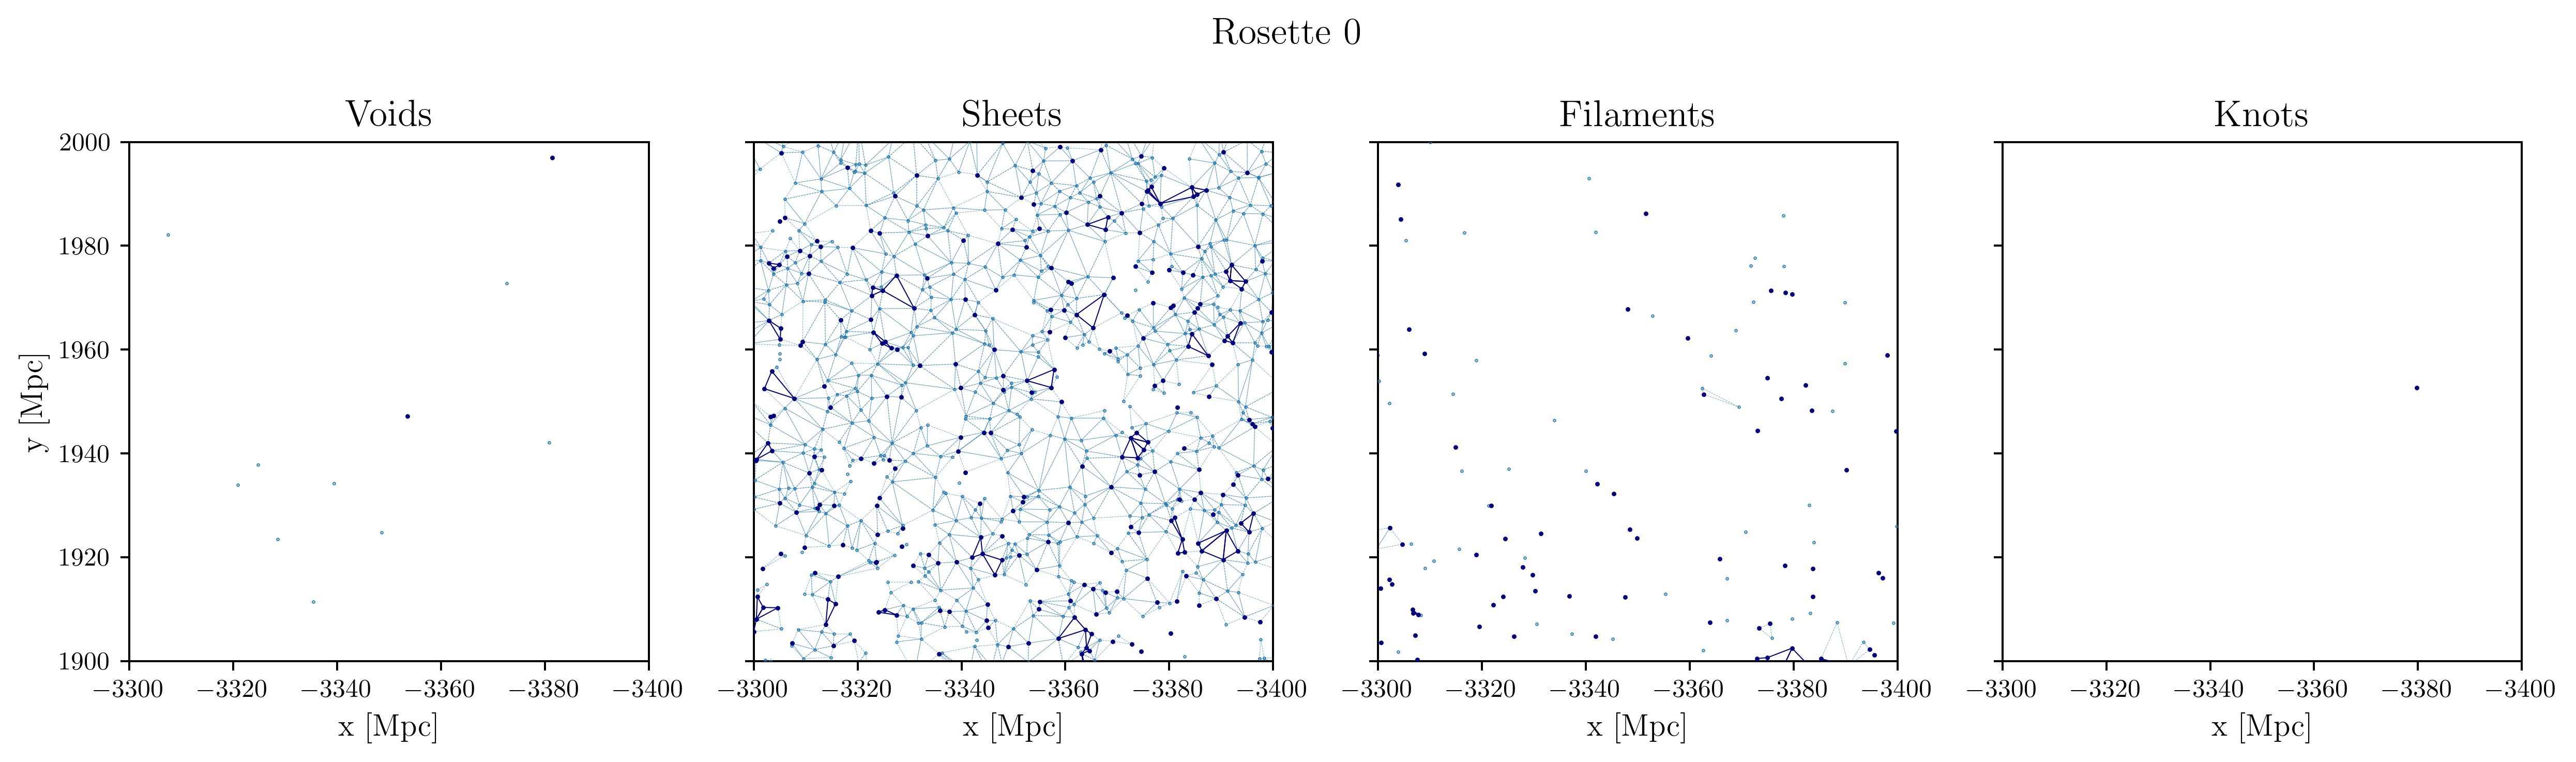

In [92]:
fig, axes = plt.subplots(1, 4, figsize=(14,4), sharey=True)

for ax, tp in zip(axes, types): #!!! se demora mucho

    mask_t = (df['TYPE'] == tp).values
    mask_real = mask_t & is_real
    mask_rand = mask_t & ~is_real

    tris = [simp for simp in tri.simplices
            if mask_t[simp].all()]

    for simplex in tris:
        verts = simplex
        xs, ys = coords2d[verts, 0], coords2d[verts, 1]
        xs, ys = np.append(xs, xs[0]), np.append(ys, ys[0])

        if mask_real[verts].all():
            ax.plot(xs, ys, '-', color='navy', alpha=1.0,
                    linewidth=0.4, zorder=10)
        else:
            ax.plot(xs, ys, '--', color='tab:blue', alpha=0.6,
                    linewidth=0.2, zorder=0)

    ax.scatter(coords2d[mask_rand,0], coords2d[mask_rand,1], s=0.1,
               c='tab:blue', zorder=5, label='random')
    ax.scatter(coords2d[mask_real,0], coords2d[mask_real,1], s=0.6,
               c='navy', zorder=10, label='real')

    ax.set_title(f'{tp.capitalize()}s')
    ax.set_box_aspect(1)
    ax.set_xlabel('x [Mpc]')
    if ax is axes[0]:
        ax.set_ylabel('y [Mpc]')

    ax.set_xlim(-3300, -3400)
    ax.set_ylim(1900, 2000)

plt.suptitle(f'Rosette {r_id}')#, y=1.01)
plt.tight_layout()
plt.show()

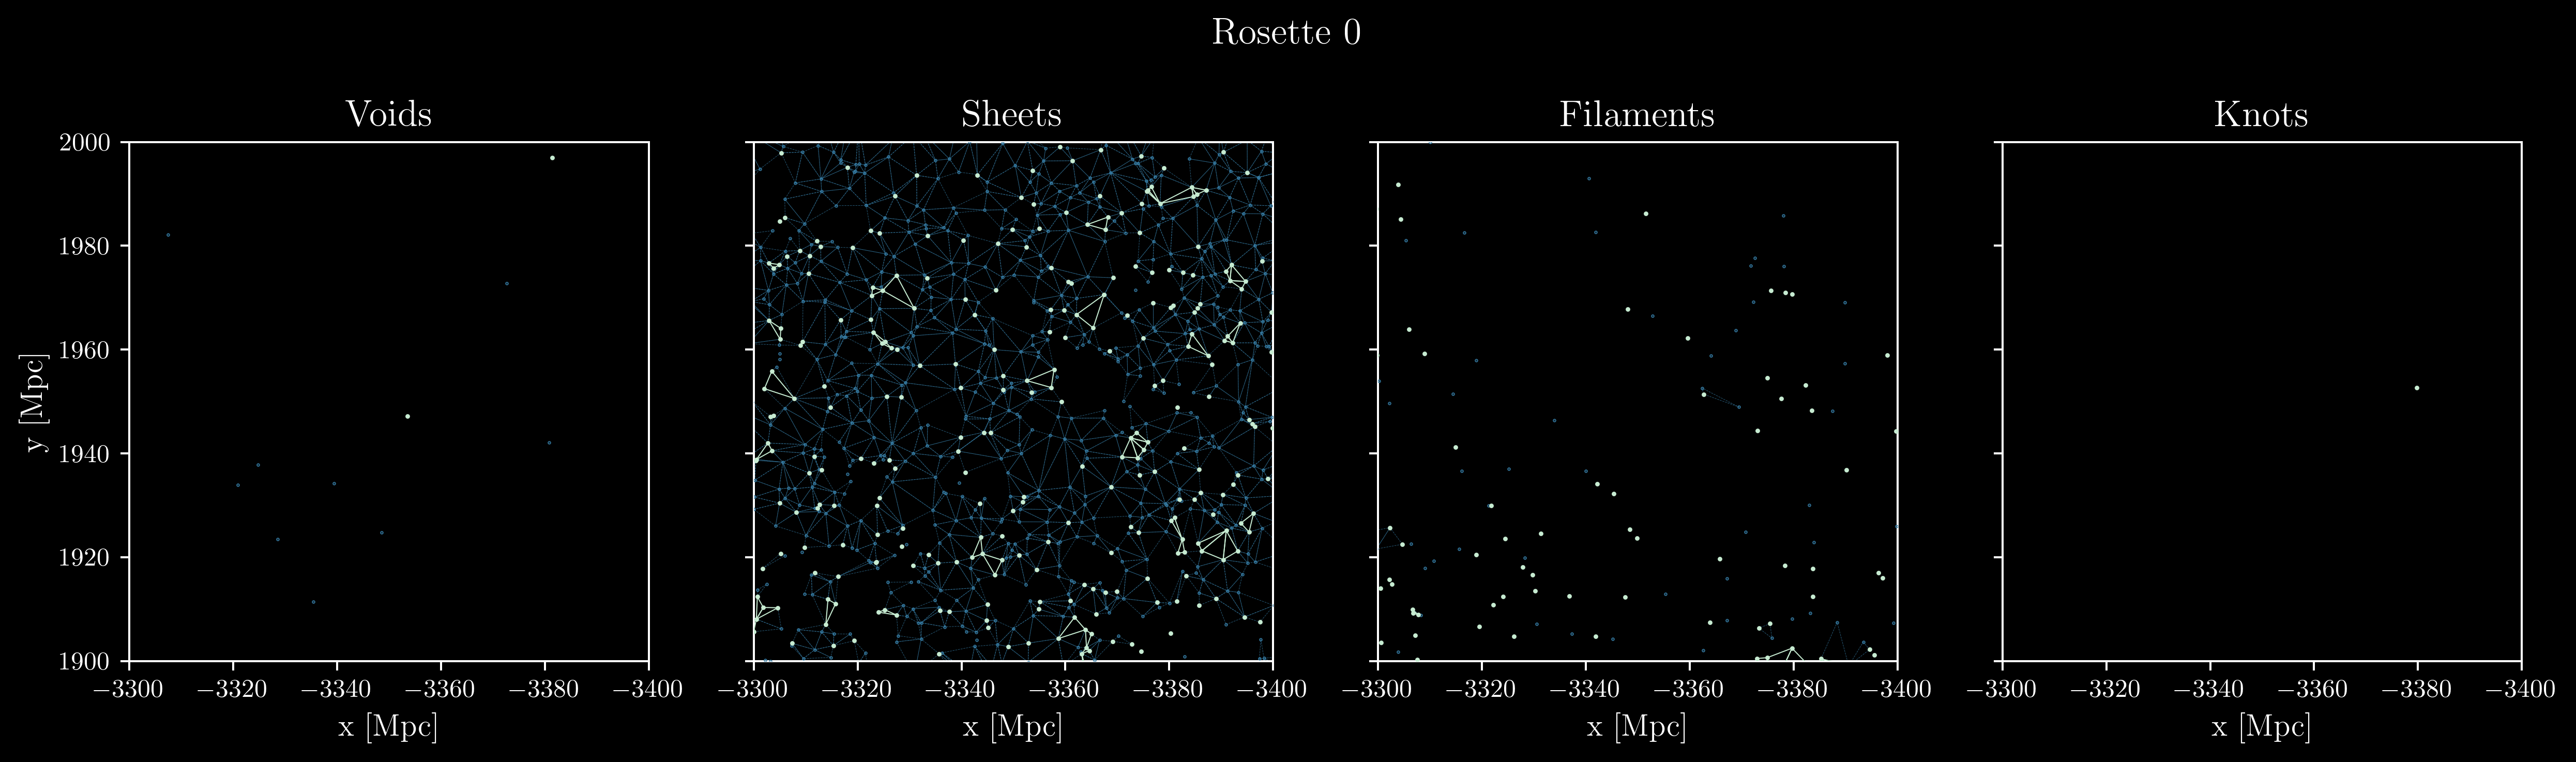

In [95]:
plt.style.use('dark_background')

fig, axes = plt.subplots(1, 4, figsize=(14,4), sharey=True)

for ax, tp in zip(axes, types):

    mask_t = (df['TYPE'] == tp).values
    mask_real = mask_t & is_real
    mask_rand = mask_t & ~is_real

    tris = [simp for simp in tri.simplices
            if mask_t[simp].all()]

    for simplex in tris:
        verts = simplex
        xs, ys = coords2d[verts, 0], coords2d[verts, 1]
        xs, ys = np.append(xs, xs[0]), np.append(ys, ys[0])

        if mask_real[verts].all():
            ax.plot(xs, ys, '-', color=cmap1(0.95), alpha=1.0,
                    linewidth=0.4, zorder=10)
        else:
            ax.plot(xs, ys, '--', color=cmap1(0.5), alpha=0.7,
                    linewidth=0.2, zorder=0)

    ax.scatter(coords2d[mask_rand,0], coords2d[mask_rand,1], s=0.1,
               c=[cmap1(0.5)], zorder=5, label='random')
    ax.scatter(coords2d[mask_real,0], coords2d[mask_real,1], s=0.6,
               c=[cmap1(0.95)], zorder=10, label='real')

    ax.set_title(f'{tp.capitalize()}s')
    ax.set_box_aspect(1)
    ax.set_xlabel('x [Mpc]')
    if ax is axes[0]:
        ax.set_ylabel('y [Mpc]')

    ax.set_xlim(-3300, -3400)
    ax.set_ylim(1900, 2000)

plt.suptitle(f'Rosette {r_id}')#, y=1.01)
plt.tight_layout()
plt.show()